# Notebook 7b: 

simple plot ipsi contra combined win stay and lose switch conditions. recordings from the right side hemisphere. 

In [1]:
import os
from pathlib import Path
import pickle
import matplotlib.pyplot as plt

In [2]:
import Notebook_7_helper_functions as Nb_7


# Needs to be updated if more notebooks 3s are added: 


In [3]:
Nb_name= 'Notebook_7_b'
period_of_interest = "combined_periods_1"

In [4]:
mouse = 'T240'
data_day = '2019_09_27__T240'
date = '2019_09_27'

HowManyBack = 1

seq_str= "0a1b2a3a4abcde5a6a7b"

data_dir_output = "/Users/gilmandelbaum/Desktop/outPut"

y_axis_list = ["df_f","z_score","z_score_sliding_window"]

In [5]:
# Parameters
data_dir_input = "/Volumes/GilInVivoPaper.large/2.Photometry_in_str/raw_data_final"
data_dir_output = "/Volumes/GilInVivoPaper.large/2.Photometry_in_str/2.raw_data_final_output_new_version/"
drop2blocks = "yes"
drop2lastblocks = "yes"
seq_str = "0a1b2a3c4abcde5a6a7b"
HowManyBack = 1
Nb0 = "a"
Nb1 = "b"
Nb2 = "a"
Nb3 = "c"
Nb4 = ["a", "b", "c", "d", "e"]
Nb5 = "a"
Nb6 = "a"
Nb7 = "b"
Tags = [
    "Reward_NoReward_tag",
    "ENL_tag",
    "Cue_to_Sel_tag",
    "Cue_to_Sel_fromPrevTrial_tag",
    "firstENLp_tag",
]
Timing = [600, 200, 15, 15, 20]
Start_or_end = ["start", "end", "start", "start", "start"]
y_axis_list = ["df_f", "z_score", "z_score_sliding_window"]
mouse = "T240"
data_day = "2019_09_27__T240"
date = "2019_09_27"
photo_day = "T240-145905"


same for all 7 notebooks

In [6]:
alphabet = ["a","b","c","d","e","f","g"]
y_axis = y_axis_list[alphabet.index(seq_str[:seq_str.index('4')][-1])]
print (y_axis)

z_score_sliding_window


In [7]:
version_to_import = seq_str[:seq_str.index('7')][-1]

In [8]:
root = Path(data_dir_output+"/"+mouse+"/"+data_day+'/'+str(HowManyBack)+"_Back")
d = mouse+"_"+date+"Notebook_6_"+version_to_import+"_"+'seq'+seq_str[:seq_str.index('7')]+'.pickle'

my_path = root / d 
print (my_path)
        
# open a file, where you stored the pickled data
fileToOpen = open(my_path, 'rb')
# load the pickle: 
PhotoData_perTrial_channels = pickle.load(fileToOpen)      

/Volumes/GilInVivoPaper.large/2.Photometry_in_str/2.raw_data_final_output_new_version/T240/2019_09_27__T240/1_Back/T240_2019_09_27Notebook_6_a_seq0a1b2a3c4abcde5a6a.pickle


In [9]:
# stash result in a cache directory, for how many back. 
cache_dir_plt = os.path.join(data_dir_output+'/'+mouse+'/'+data_day, str(HowManyBack)+'_Back',"0.plots","session_plots_"+y_axis)
if not os.path.exists(cache_dir_plt):
    os.makedirs(cache_dir_plt)    

In [10]:
path_to_plot = cache_dir_plt+"/"+seq_str
print (path_to_plot)

/Volumes/GilInVivoPaper.large/2.Photometry_in_str/2.raw_data_final_output_new_version//T240/2019_09_27__T240/1_Back/0.plots/session_plots_z_score_sliding_window/0a1b2a3c4abcde5a6a7b


In [11]:
# def extract_rl_tt_period_celltype_mean(PhotoData_perTrial_channels,rl,tt,period,cell_type):
    
#     number_of_trials = len(PhotoData_perTrial_channels[rl][0][tt][period][cell_type].columns)
    
#     mean_ipsi_next = PhotoData_perTrial_channels[rl][0][tt][period][cell_type].mean(axis=1)
#     mean_contra_next = PhotoData_perTrial_channels[rl][1][tt][period][cell_type].mean(axis=1)
    
#     sem_ipsi_next = (PhotoData_perTrial_channels[rl][0][tt][period][cell_type].std(axis=1))/(number_of_trials**0.5)
#     sem_contra_next = PhotoData_perTrial_channels[rl][1][tt][period][cell_type].std(axis=1)/(number_of_trials**0.5)
    
    
#     return (mean_ipsi_next,sem_ipsi_next,mean_contra_next,sem_contra_next,number_of_trials)


In [12]:
# def calculate_sem (data):
#     sem_up_ipsi_next = data[0]+data[1]/2
#     sem_down_ipsi_next = data[0]-data[1]/2
    
#     sem_up_contra_next = data[2]+data[3]/2
#     sem_down_contra_next = data[2]-data[3]/2
    
#     return (sem_up_ipsi_next,sem_down_ipsi_next,sem_up_contra_next,sem_down_contra_next)


In [13]:
# def plot_ipsi_contra_together (data,sem,trial_type,cell_type,y_axis,path_to_plot):

#     plt.plot(data[0],linewidth=2, label="ipsi_next"+" "+"("+str(data[4])+")")
#     plt.plot(data[2],linewidth=2, label="contra_next"+" "+"("+str(data[4])+")")
    
#     plt.plot(sem[0],color='black', linewidth=0.5,alpha=0.8)
#     plt.plot(sem[1],color='black', linewidth=0.5,alpha=0.8)
#     plt.plot(sem[2],color='black', linewidth=0.5,alpha=0.8)
#     plt.plot(sem[3],color='black', linewidth=0.5,alpha=0.8)
    
#     # Add legend
#     plt.legend(loc='lower left')
    
#     # Add title and x, y labels
#     plt.title(trial_type, fontsize=16, fontweight='bold')
#     plt.suptitle(cell_type, fontsize=16)

#     plt.xlabel("time_bins")

#     #the y axis is defined in the paper mill. This allows to run 7_b with 3a,3b,3c and any future 3s, easliy changing the 
#     #the name of the y axis to not cause confusion. 
#     plt.ylabel(y_axis)
#     plt.savefig(path_to_plot+"_"+trial_type+cell_type+'.pdf')
#     plt.show()
    

In [14]:
r_ls_combined_periods_1_d1 = Nb_7.extract_rl_tt_period_celltype_mean (PhotoData_perTrial_channels,0,0,
                                                                      "combined_periods_1","d1 R")

In [15]:
r_ls_combined_periods_1_d1_sem = Nb_7.calculate_sem (r_ls_combined_periods_1_d1)

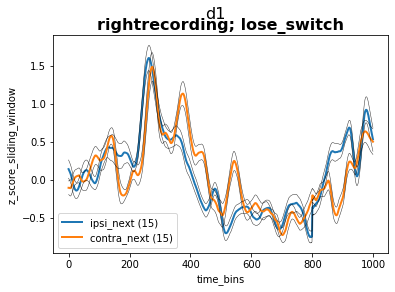

In [16]:
Nb_7.plot_ipsi_contra_together(r_ls_combined_periods_1_d1,r_ls_combined_periods_1_d1_sem,"rightrecording; lose_switch",
                               "d1",y_axis,path_to_plot)

In [17]:
r_ls_combined_periods_1_d2 = Nb_7.extract_rl_tt_period_celltype_mean (PhotoData_perTrial_channels,0,0,
                                                                      "combined_periods_1","d2 R")

In [18]:
r_ls_combined_periods_1_d2_sem = Nb_7.calculate_sem(r_ls_combined_periods_1_d2)

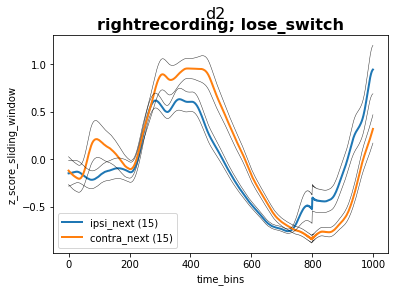

In [19]:
Nb_7.plot_ipsi_contra_together(r_ls_combined_periods_1_d2,r_ls_combined_periods_1_d2_sem,"rightrecording; lose_switch",
                               "d2",y_axis,path_to_plot)

In [20]:
r_wr_combined_periods_1_d1 = Nb_7.extract_rl_tt_period_celltype_mean (PhotoData_perTrial_channels,0,3,
                                                                      "combined_periods_1","d1 R")

In [21]:
r_wr_combined_periods_1_d1_sem = Nb_7.calculate_sem(r_wr_combined_periods_1_d1)

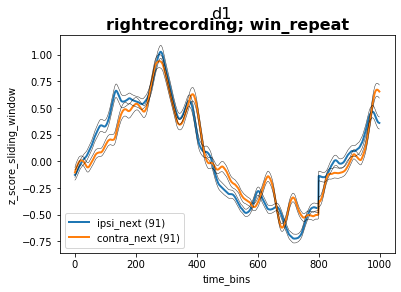

In [22]:
Nb_7.plot_ipsi_contra_together(r_wr_combined_periods_1_d1,r_wr_combined_periods_1_d1_sem,"rightrecording; win_repeat",
                               "d1",y_axis,path_to_plot)

In [23]:
r_wr_combined_periods_1_d2 = Nb_7.extract_rl_tt_period_celltype_mean (PhotoData_perTrial_channels,0,3,
                                                                      "combined_periods_1","d2 R")

In [24]:
r_wr_combined_periods_1_d2_sem = Nb_7.calculate_sem(r_wr_combined_periods_1_d2)

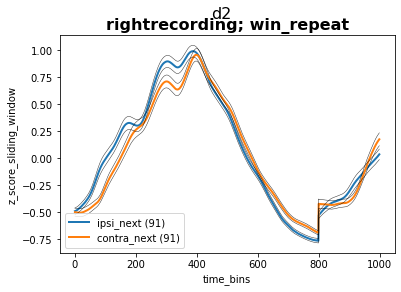

In [25]:
Nb_7.plot_ipsi_contra_together(r_wr_combined_periods_1_d2,r_wr_combined_periods_1_d2_sem,"rightrecording; win_repeat",
                               "d2",y_axis,path_to_plot)

In [26]:
root = Path(data_dir_output+"/"+mouse+"/"+data_day+'/'+str(HowManyBack)+"_Back")
d = mouse+"_"+date+Nb_name+'_seq'+seq_str+'.pickle'
my_path = root / d 
my_file = open(my_path, 'wb')
my_file = pickle.dump((),my_file)